In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [1]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

In [2]:
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "financial_agents"

In [3]:
from langchain_core.messages import convert_to_messages
from langgraph.prebuilt import create_react_agent
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
final_prompt = """ 
You are a world-class strategy consultant trained by Alvarez & Marsal. Act as if you have been hired
to provide strategic market intelligence analysis for a client in the electric power transmission sector
operating in Brazil. Companies to be analyzed: Taesa, ISA CTEEP, Eletrobras, Engie, Alupar

Delivery format:
• At the end of each table, provide objective comments and insights on trends, differences between companies, and strategic implications.
• Structure the report as if you were pasting it directly into slides for a meeting with the board and C-level executives.
• Use bold and arrows to highlight relevant rankings and variations.
• Be succinct and prioritize clarity and comparability.
Think like an Alvarez & Marsal partner presenting executive recommendations.
• When data is missing or not indicated in the data, do not invent values. Just indicate this in the analysis.
• For analyses involving regulations, carefully explain the concept used, whether it was IFRS, whether it is potential or achieved, etc.
"""



In [5]:
analyses = {
    "[MARKET] Analysis 1": "Identify the participation of the main players. List the line extension in kilometers, the share of the total national network in percentage, and the number of concessions currently in operation.",
    "[MARKET] Analysis 2": "Calculate the market share in ANEEL 2024 auctions. Provide the number of lots awarded per company, the total investment in BRL billion, the average offered IRR compared to the ANEEL reference, and the percentage participation in the total auctioned volume.",
    "[FINANCIAL PERFORMANCE] Analysis 3": "Report the regulated net revenue for the 12 months of 2024, the regulatory EBITDA for the same period, and the regulatory net income.",
    "[FINANCIAL PERFORMANCE] Analysis 4": "Compare Market Cap and EBITDA. State the Market Cap in 4Q24 and present the comparison between real EBITDA and regulatory EBITDA, highlighting the absolute and percentage differences.",
    "[CAPITAL STRUCTURE] Analysis 5": "Analyze leverage and returns. Calculate the Net Debt to Real EBITDA ratio for 4Q24, and report the Return on Assets (RoA), Return on Equity (RoE), and Return on Capital Employed (RoCe).",
    "[EXPANSION AND PERFORMANCE] Analysis 6": "Assess investments and operational performance. Summarize the annual CapEx from 2022 to 2024 and indicate the percentage related to greenfield projects. List the main projects exceeding R$300 million, describe O&M costs and their drivers, report grid availability, PV/RAP ratio, PV events, and detail ANEEL penalties along with the number of failures per 1,000 km."
}


In [6]:

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [7]:
def plot_bar_chart(data: dict, dtypes: dict, category_col: str, value_col: str):
    """Create a bar chart comparing values across categories."""
    df = pd.DataFrame.from_dict(data).astype(dtypes)
    df.plot(kind='bar', x=category_col, y=value_col, legend=False)
    plt.xlabel(category_col)
    plt.ylabel(value_col)
    plt.title(f"{value_col} by {category_col}")
    plt.tight_layout()
    plt.show()

def plot_line_chart(data: dict, dtypes: dict, x_col: str, y_col: str):
    """Create a line chart to visualize a trend over time."""
    df = pd.DataFrame.from_dict(data).astype(dtypes)
    df.plot(kind='line', x=x_col, y=y_col, marker='o')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} over {x_col}")
    plt.tight_layout()
    plt.show()

def plot_histogram(data: dict, dtypes: dict, column: str, bins: int = 10):
    """Create a histogram to show the distribution of a numerical variable."""
    df = pd.DataFrame.from_dict(data).astype(dtypes)
    plt.hist(df[column], bins=bins, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column}")
    plt.tight_layout()
    plt.show()

def plot_scatter_plot(data: dict, dtypes: dict, x_col: str, y_col: str):
    """Create a scatter plot to visualize correlation between two variables."""
    df = pd.DataFrame.from_dict(data).astype(dtypes)
    plt.scatter(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")
    plt.tight_layout()
    plt.show()

def recommend_chart(data: dict, dtypes: dict) -> str:
    """
    Recommend a suitable chart type for a given dataset.
    Returns one of: line chart, bar chart, histogram chart, scatter chart, unknown
    """
    df = pd.DataFrame.from_dict(data).astype(dtypes)
    num_cols = df.select_dtypes(include="number").columns.tolist()
    cat_cols = df.select_dtypes(include="object").columns.tolist()

    if "date" in df.columns or any("date" in col.lower() for col in df.columns):
        return "line chart"
    elif len(cat_cols) == 1 and len(num_cols) == 1:
        return "bar chart"
    elif len(num_cols) == 1:
        return "histogram chart"
    elif len(num_cols) >= 2:
        return "scatter chart"
    else:
        return "unknown"

charts_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[plot_bar_chart, plot_line_chart, plot_histogram,
           plot_scatter_plot, recommend_chart],
    prompt=(
    "You are a data analyst agent.\n\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with data analysis tasks (plotting charts)\n"
    "- Use the available tools to load and visualize data passed\n"
    "- After you're done with your tasks, respond to the supervisor directly\n"
    "- Respond ONLY with the results of your work (e.g., charts, data summaries), do NOT include ANY other text."
    ),
    name="charts_agent",
)

In [19]:
from langchain_openai import ChatOpenAI

insights_agent = create_react_agent(
    model=ChatOpenAI(model_name="gpt-4.1", temperature=0.2),
    tools=[],
    prompt=(
        "You are an insights agent.\n\n"
        "INSTRUCTIONS:\n"
        "- You will receive a dataset in JSON format.\n"
        "- Carefully review the data.\n"
        "- Provide objective comments on trends, differences between companies, and strategic implications.\n"
        "- Summarize key patterns in clear, concise sentences.\n"
        "- Respond ONLY with your insights—no extra formatting or disclaimers.\n\n"
        "DATA:\n"
        "{data}"
    ),
    name="insights_agent",
)


In [22]:
def get_company_names(data: dict) -> str:
    """Returns a comma-separated list of unique company names."""
    df = pd.DataFrame.from_dict(data)
    companies = df["Company"].unique().tolist()
    return ", ".join(companies)

summarizer_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[get_company_names],
    prompt = (
        "You are a summarizer agent.\n\n"
        "INSTRUCTIONS:\n"
        "- You will receive a dataset in JSON format.\n"
        "- First, extract the unique company names using the available tool.\n"
        "- Then, for EACH company, write a detailed company profile.\n\n"
        "For each company profile, include 3 paragraphs:\n"
        "1) Business lines and role.\n"
        "2) Key milestones and ownership.\n"
        "3) Reputation and recent news.\n\n"
        "- Use smooth, informative sentences.\n"
        "- Do not include any financial figures.\n"
        "- Clearly separate the profiles with headings.\n\n"
        "DATA:\n"
        "{data}"
    ),
    name="summarizer_agent",
)

#### Langgraph workflow

In [23]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1"),
    agents=[
        charts_agent,
        insights_agent,
        summarizer_agent
    ],
    prompt=(
        "You are a supervisor managing three specialized agents:\n\n"
        "- A **charts agent**: Assign any tasks related to data visualization, chart creation, or graphical representation to this agent.\n"
        "- An **insights agent**: Assign tasks related to data interpretation, commenting, or providing analytical insights to this agent.\n"
        "- A **summarizer agent**: Assign tasks related to writing detailed company profiles or summarizing company-related information to this agent.\n\n"
        "RULES:\n"
        "- Assign work to only **one agent at a time**.\n"
        "- Do not call multiple agents in parallel.\n"
        "- Do not do any analysis, visualization, or summarization yourself.\n"
        "- Always clearly specify which agent should handle each request."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()


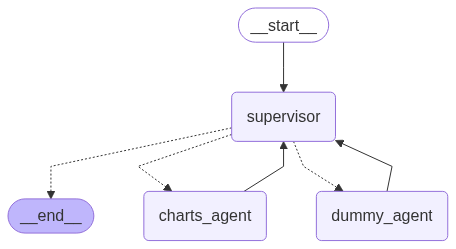

In [10]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

### Melhoria de pipeline

Leitura dos PDFs de releases financeiros. 

In [11]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
import pymupdf4llm

def paper_analyzer(path):
    print("ANALYZE PDF RELEASE")

    # Converte o PDF em Markdown
    md_text = pymupdf4llm.to_markdown(path)

    # Aqui definimos a pergunta fictícia
    question = "Summarize the main financial highlights of this release in bullet points."

    # Prompt de sistema (pode customizar)
    system_prompt = (
        "You are a financial analyst AI. "
        "Answer the user's question based on the provided document content."
    )

    # Mensagens que vão para o modelo
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"{md_text}\n\nQuestion: {question}")
    ]

    # Invoca o modelo
    model = ChatOpenAI(model="gpt-4o")
    response = model.invoke(messages, temperature=0.1)

    print("Model response:")
    print(response.content)

    # Retorna o resultado em dict
    return {
        "analyses": [response.content]
    }


In [12]:
paper_analyzer(path = 'data/releases/isa-4T24.pdf')

ANALYZE PDF RELEASE
Model response:
- **Lucro Líquido**: R$ 810,1 milhões, uma redução de 10,0% em relação ao 4T23.
- **Dívida Líquida**: R$ 10.229,8 milhões, um aumento de 29,4% em comparação ao ano anterior.
- **EBITDA**: R$ 794,3 milhões, uma queda de 3,9% em relação ao 4T23.
- **CapEx**: R$ 1.291,3 milhões, um aumento significativo de 75,8% em relação ao ano anterior.
- **Receita Líquida**: R$ 1.156,6 milhões no 4T24, um aumento de 4,2% em relação ao 4T23.
- **Margem EBITDA**: 68,7%, uma redução de 5,8 pontos percentuais em relação ao 4T23.
- **ROE (Retorno sobre o Patrimônio Líquido)**: 20,9%, uma redução de 4,9 pontos percentuais em relação ao ano anterior.
- **Investimentos em Reforços e Melhorias**: R$ 1.371,4 milhões em 2024, um aumento de 12,4% em relação a 2023.
- **Investimentos em Projetos Greenfield**: R$ 2.263,2 milhões em 2024, um aumento de 167,3% em relação a 2023.


{'analyses': ['- **Lucro Líquido**: R$ 810,1 milhões, uma redução de 10,0% em relação ao 4T23.\n- **Dívida Líquida**: R$ 10.229,8 milhões, um aumento de 29,4% em comparação ao ano anterior.\n- **EBITDA**: R$ 794,3 milhões, uma queda de 3,9% em relação ao 4T23.\n- **CapEx**: R$ 1.291,3 milhões, um aumento significativo de 75,8% em relação ao ano anterior.\n- **Receita Líquida**: R$ 1.156,6 milhões no 4T24, um aumento de 4,2% em relação ao 4T23.\n- **Margem EBITDA**: 68,7%, uma redução de 5,8 pontos percentuais em relação ao 4T23.\n- **ROE (Retorno sobre o Patrimônio Líquido)**: 20,9%, uma redução de 4,9 pontos percentuais em relação ao ano anterior.\n- **Investimentos em Reforços e Melhorias**: R$ 1.371,4 milhões em 2024, um aumento de 12,4% em relação a 2023.\n- **Investimentos em Projetos Greenfield**: R$ 2.263,2 milhões em 2024, um aumento de 167,3% em relação a 2023.']}

In [13]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
import pymupdf4llm
import os

def analyze_all(folder_path="data/releases/"):
    print("ANALYZE MULTIPLE PDF RELEASES")
    combined_results = []

    # Lista todos os PDFs na pasta
    pdf_files = [f for f in os.listdir(folder_path) if f.endswith(".pdf")]

    # Define o prompt filtrado acima
    system_prompt = (
        "You are a financial data extraction AI. "
        "Return only structured JSON with the requested raw numerical data, no commentary."
    )

    question = (
        "Extract only the raw numerical data from this document in a structured JSON format. "
        "For any data point not explicitly found, return `NaN`. Ignore commentary, explanations, or analysis.\n\n"
        "Collect the following data:\n\n"
        "[FINANCIAL PERFORMANCE]\n"
        "• Net revenue for the 12 months of 2024.\n"
        "• EBITDA for the 12 months of 2024.\n"
        "• Net income for the 12 months of 2024.\n"
        "• Return on Equity (RoE) in 2024.\n"
        "• Net Debt as of December 31, 2024.\n"
        "• Total investments or CapEx in 2024.\n\n"
        "Note: If any of these data points are missing in the document, output `NaN`."
    )

    # Processa cada PDF
    for pdf_file in pdf_files:
        print(f"\nProcessing {pdf_file}...")
        md_text = pymupdf4llm.to_markdown(os.path.join(folder_path, pdf_file))

        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"{md_text}\n\nQuestion: {question}")
        ]

        model = ChatOpenAI(model="gpt-4o")
        response = model.invoke(messages, temperature=0.1)

        print("Model response:")
        print(response.content)

        combined_results.append({
            "file": pdf_file,
            "data": response.content
        })

    return combined_results

In [14]:
results = analyze_all()

ANALYZE MULTIPLE PDF RELEASES

Processing alupar-4T24.pdf...
Model response:
```json
{
  "FINANCIAL_PERFORMANCE": {
    "Net_revenue_2024": 4002.1,
    "EBITDA_2024": 3070.8,
    "Net_income_2024": 1859.9,
    "Return_on_Equity_2024": "NaN",
    "Net_Debt_2024": 9138.8,
    "Total_investments_CapEx_2024": 470.2
  }
}
```

Processing eletrobras-4T24.pdf...
Model response:
```json
{
  "FINANCIAL_PERFORMANCE": {
    "Net_revenue_12M24": 40182,
    "EBITDA_12M24": 26237,
    "Net_income_12M24": 10381,
    "Return_on_Equity_2024": 8.5,
    "Net_Debt_31_12_2024": 37671,
    "Total_investments_2024": 7709
  }
}
```

Processing engie-4T24.pdf...
Model response:
```json
{
  "FINANCIAL_PERFORMANCE": {
    "Net_revenue_12M_2024": 11219,
    "EBITDA_12M_2024": 8754,
    "Net_income_12M_2024": 4303,
    "Return_on_Equity_2024": "NaN",
    "Net_Debt_31_12_2024": 20126,
    "Total_investments_CapEx_2024": 9664
  }
}
```

Processing isa-4T24.pdf...
Model response:
```json
{
  "FINANCIAL_PERFORMANCE": 

In [15]:
import pandas as pd
import json
import re

def convert_financial_data(records):
    """
    Converte a lista de dicts com dados financeiros em um pandas DataFrame limpo.
    """
    rows = []

    for entry in records:
        file_name = entry["file"]
        
        # Remove marcações ```json e ```
        clean_json = re.sub(r"^```json\n|```$", "", entry["data"].strip())
        
        # Parse JSON
        data = json.loads(clean_json)
        fin = data.get("FINANCIAL_PERFORMANCE", {})
        
        # Normaliza nomes de campos
        row = {
            "Company": file_name.split('-')[0].strip().capitalize(),  # Extrai o nome da empresa do nome do arquivo
            "Net_revenue_2024": (
                fin.get("Net_revenue_12M24") or
                fin.get("Net_revenue_12M_2024") or
                fin.get("Net_revenue_2024")
            ),
            "EBITDA_2024": (
                fin.get("EBITDA_12M24") or
                fin.get("EBITDA_12M_2024") or
                fin.get("EBITDA_2024")
            ),
            "Net_income_2024": (
                fin.get("Net_income_12M24") or
                fin.get("Net_income_12M_2024") or
                fin.get("Net_income_2024")
            ),
            "Return_on_Equity_2024": fin.get("Return_on_Equity_2024"),
            "Net_Debt_2024": (
                fin.get("Net_Debt_31_12_2024") or
                fin.get("Net_Debt_2024")
            ),
            "Total_investments_CapEx_2024": (
                fin.get("Total_investments_2024") or
                fin.get("Total_investments_CapEx_2024")
            )
        }
        
        rows.append(row)
    
    # Criar DataFrame
    df = pd.DataFrame(rows)
    
    # Converter "NaN" string em valores nulos
    df = df.replace("NaN", pd.NA)
    
    # Converter colunas numéricas
    numeric_cols = [
        "Net_revenue_2024",
        "EBITDA_2024",
        "Net_income_2024",
        "Return_on_Equity_2024",
        "Net_Debt_2024",
        "Total_investments_CapEx_2024"
    ]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    
    return df



df_results = convert_financial_data(results)

In [ ]:
df_results

,Company,Net_revenue_2024,EBITDA_2024,Net_income_2024,Return_on_Equity_2024,Net_Debt_2024,Total_investments_CapEx_2024
0,Alupar,4002.1,3070.8,1859.9,NaN,9138.8,470.2
1,Eletrobras,40182.0,26237.0,10381.0,8.5,37671.0,7709.0
2,Engie,11219.0,8754.0,4303.0,NaN,20126.0,9664.0
3,Isa,7966.6,3541.0,2076.6,20.9,10229.8,2263.2
4,Taesa,3718.1,1953.2,1693.9,NaN,9057.5,1035.4


### Company Summaries

In [17]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Initialize ChatGPT 
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)



prompt = PromptTemplate(
    input_variables=["company_name"],
    template = """
        Write a detailed company profile of {company_name}, an energy company in Brazil. 
        Provide 3 clear paragraphs: 1) business lines and role; 
        2) key milestones and ownership; 
        3) reputation and recent news. 
        Use smooth, informative sentences. No financial figures. 
    """
    )

chain = LLMChain(llm=llm, prompt=prompt)

C:\Users\gorleans\AppData\Local\Temp\ipykernel_14352\1459359920.py:20: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


In [18]:
summaries = {}

for idx, content in enumerate(df_results['Company']):
    if not isinstance(content, str) or len(content.strip()) == 0:
        summaries[idx] = "⚠️ Conteúdo vazio ou não encontrado."
        continue

    try:
        summary = chain.run({"company_name": content.strip()})
        summaries[idx] = summary.strip()
    except Exception as e:
        summaries[idx] = f"Erro ao resumir: {str(e)}"


C:\Users\gorleans\AppData\Local\Temp\ipykernel_14352\3527924352.py:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = chain.run({"company_name": content.strip()})


In [19]:
summaries

{0: 'Alupar is a prominent Brazilian energy company specializing in the generation and transmission of electric power. The company operates a diversified portfolio that includes hydroelectric, wind, and solar power plants, as well as an extensive network of transmission lines. By focusing on renewable energy sources and infrastructure development, Alupar plays a critical role in supporting Brazil’s energy matrix and ensuring the reliable delivery of electricity across various regions of the country. Its integrated approach allows the company to contribute significantly to the sustainability and modernization of Brazil’s power sector.\n\nSince its inception, Alupar has achieved several key milestones that have solidified its position in the energy industry. The company was established with a strategic vision to expand Brazil’s energy infrastructure and has grown through a combination of organic development and acquisitions. Over the years, Alupar has successfully commissioned numerous p

### Plot charts based on results

In [20]:
df_results

,Company,Net_revenue_2024,EBITDA_2024,Net_income_2024,Return_on_Equity_2024,Net_Debt_2024,Total_investments_CapEx_2024
0,Alupar,4002.1,3070.8,1859.9,NaN,9138.8,470.2
1,Eletrobras,40182.0,26237.0,10381.0,NaN,37671.0,7709.0
2,Engie,11219.0,8754.0,4303.0,NaN,20126.0,9664.0
3,Isa,7966.6,3541.0,2076.6,20.9,10229.8,2263.2
4,Taesa,3718.1,1953.2,1693.9,NaN,9057.5,1035.4


In [21]:
num_cols = df_results.select_dtypes('float64').columns.to_list()

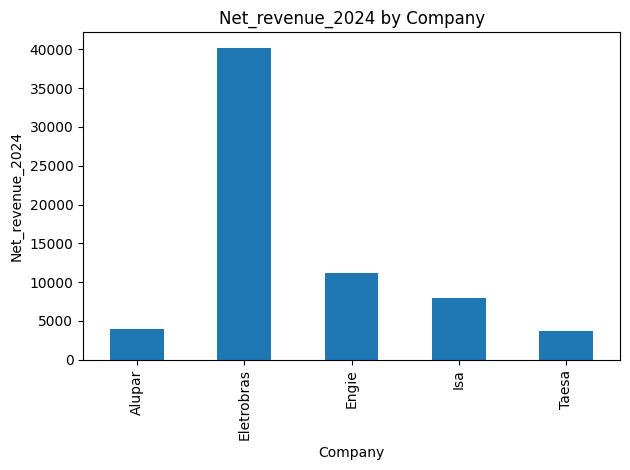

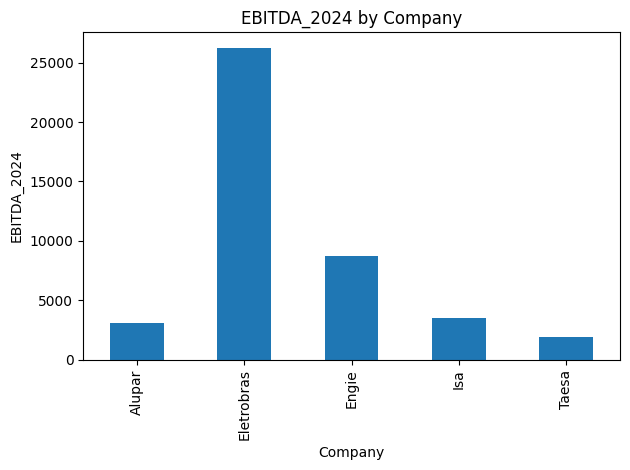

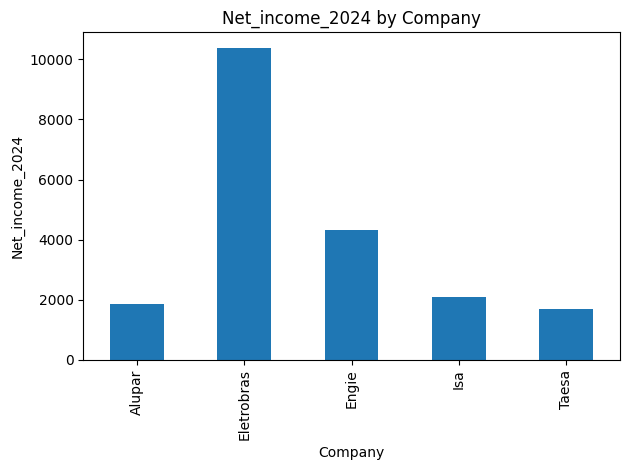

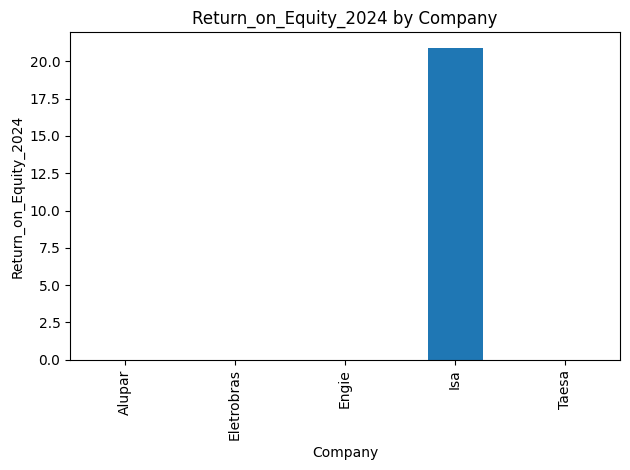

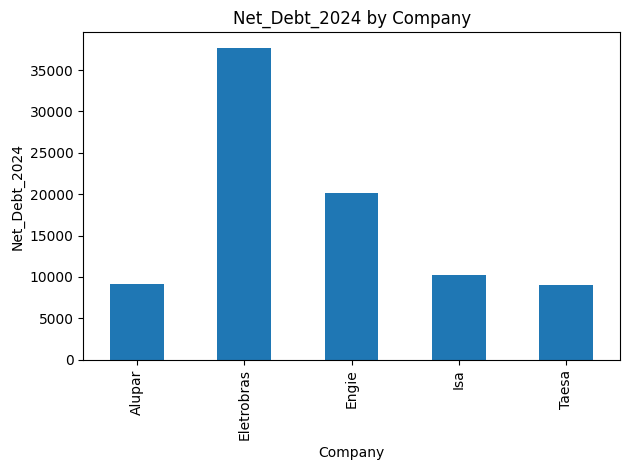

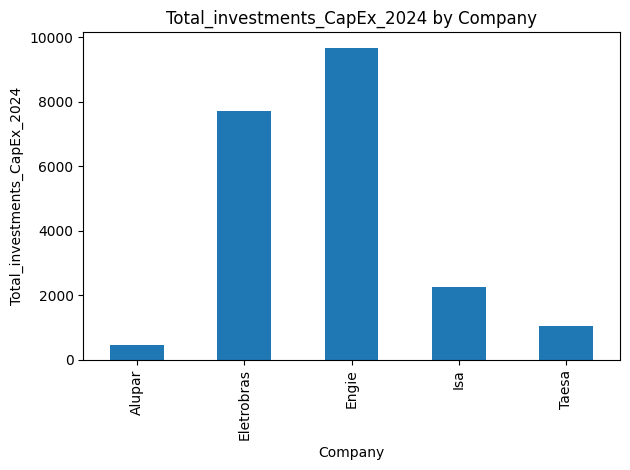

In [31]:
for col in num_cols:

    plot_bar_chart(
        data=df_results.to_dict(orient="records"),
        dtypes={k: str(v) for k, v in df_results.dtypes.items()},
        category_col="Company",
        value_col=col
    )


### Extract insights based on data